In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd gdrive/MyDrive/cs334/data/

/content/gdrive/MyDrive/cs334/data


In [ ]:
!ls

july.csv  june.csv  may.csv  xTest.csv	xTrain.csv  yTest.csv  yTrain.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
xTrain = pd.read_csv('xTrain.csv')
xTest = pd.read_csv('xTest.csv')
yTrain = pd.read_csv('yTrain.csv')
yTest = pd.read_csv('yTest.csv')

In [ ]:
%cd ../models

/content/gdrive/MyDrive/cs334/models


In [ ]:
%cd ../data

/content/gdrive/My Drive/cs334/data


In [ ]:
# when read, these become int again, thus need mapping
xTrain['DAY_OF_MONTH'] = xTrain['DAY_OF_MONTH'].map(lambda x: str(x))
xTrain['DAY_OF_WEEK'] = xTrain['DAY_OF_WEEK'].map(lambda x: str(x))
xTest['DAY_OF_MONTH'] = xTest['DAY_OF_MONTH'].map(lambda x: str(x))
xTest['DAY_OF_WEEK'] = xTest['DAY_OF_WEEK'].map(lambda x: str(x))

In [ ]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 310 kB/s 


In [ ]:
!pip install tune-sklearn ray[tune]

     |████████████████████████████████| 40 kB 3.2 MB/s 
     |████████████████████████████████| 54.7 MB 157 kB/s 
     |████████████████████████████████| 119 kB 57.2 MB/s 
     |████████████████████████████████| 124 kB 67.8 MB/s 


In [ ]:
# attempt with pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders.m_estimate import MEstimateEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, fbeta_score, plot_roc_curve, make_scorer, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
import scipy 
from ray import tune
from tune_sklearn import TuneSearchCV

In [ ]:
# up down sample
xTrain1 = xTrain[yTrain['DEP_DEL15'] == 1]
xTrain0 = xTrain[yTrain['DEP_DEL15'] == 0]
yTrain1 = yTrain[yTrain['DEP_DEL15'] == 1]
yTrain0 = yTrain[yTrain['DEP_DEL15'] == 0]
xTrain1_up32, yTrain1_up32 = resample(xTrain1, yTrain1, n_samples=xTrain0.shape[0]*2//3, random_state=42)
xTrain_up32 = pd.concat([xTrain1_up32, xTrain0])
yTrain_up32 = pd.concat([yTrain1_up32, yTrain0])
xTrain0_down, yTrain0_down = resample(xTrain0, yTrain0, n_samples=xTrain1.shape[0], random_state=42)
xTrain_down = pd.concat([xTrain0_down, xTrain1])
yTrain_down = pd.concat([yTrain0_down, yTrain1])

In [ ]:
yTrain_up['DEP_DEL15'].value_counts()

1.0    843165
0.0    843165
Name: DEP_DEL15, dtype: int64

In [ ]:
# create pipeline
# check https://scikit-learn.org/stable/modules/compose.html nested params
estimators = [('me', MEstimateEncoder()), ('ss', StandardScaler()), ('clf', RandomForestClassifier(random_state=42))]
pipe = Pipeline(estimators)
pipe

Pipeline(steps=[('me', MEstimateEncoder()), ('ss', StandardScaler()),
                ('clf', RandomForestClassifier(random_state=42))])

In [ ]:
# cheat test for what model might be better
with joblib.parallel_backend('ray'):
  pipe.fit(xTrain_up, yTrain_up['DEP_DEL15'])

In [ ]:
print(fbeta_score(yTest['DEP_DEL15'], pipe.predict(xTest), beta=2))
print(accuracy_score(yTest['DEP_DEL15'], pipe.predict(xTest)))

In [ ]:
plot_roc_curve(pipe, xTest, yTest['DEP_DEL15'])

In [ ]:
# set parameters grid, could also use RandomizedSearchCV (probably better even)
param_dists = {
    'me__m': tune.uniform(1,100),
    # 'clf__C': tune.loguniform(1e-3, 1),
    # 'clf__solver': tune.choice(['lbfgs', 'saga', 'newton-cg']),
    # 'clf__warm_start': tune.choice([True, False]),
    # 'clf__max_iter': tune.uniform(100,500)
    # 'clf__n_neighbors': tune.randint(5,500),
    'clf__n_estimators': tune.randint(0,120),
    'clf__criterion': tune.choice(['gini', 'entropy']),
    'clf__max_depth': tune.choice([None, tune.randint(2,50)]),
    'clf__min_samples_leaf': tune.randint(1,1000),
    'clf__max_samples': tune.choice([None, 0.9, 0.8, 0.7]),
    # 'clf__max_features': tune.choice([None, 0.9, 0.8, 0.7]),
    # 'clf__alpha': tune.loguniform(1e-3, 1e2),
}
scoring = {
    'f1': 'f1',
    'f2': make_scorer(fbeta_score, beta=2),
    'accuracy': 'accuracy'
}

In [ ]:
clf = TuneSearchCV(pipe,
                   param_distributions=param_dists,
                   search_optimization="random",
                   scoring=scoring,
                   refit='f2'
                   )

In [ ]:
clf.fit(xTrain_up32, yTrain_up32['DEP_DEL15'])

/usr/local/lib/python3.7/dist-packages/ray/tune/tune.py:369: UserWarning:

The `loggers` argument is deprecated. Please pass the respective `LoggerCallback` classes to the `callbacks` argument instead. See https://docs.ray.io/en/latest/tune/api_docs/logging.html

(pid=21196) /usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:
(pid=21196) 
(pid=21196) pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
(pid=21196) 
(pid=21197) /usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:
(pid=21197) 
(pid=21197) pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
(pid=21197) 
(pid=21194) /usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:
(pid=21194) 
(pid=21194) pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
(pid=21194) 
(pid=21198) /usr/local/lib/p

TuneSearchCV(estimator=Pipeline(steps=[('me', MEstimateEncoder()),
                                       ('ss', StandardScaler()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             loggers=[<class 'ray.tune.logger.CSVLogger'>,
                      <class 'ray.tune.logger.JsonLogger'>],
             mode='max', n_jobs=-1,
             param_distributions={'clf__criterion': <ray.tune.sample.Categorical object at 0x7f5601fdd690>,
                                  'clf__max_depth': <r...
                                  'clf__max_samples': <ray.tune.sample.Categorical object at 0x7f56016cb390>,
                                  'clf__min_samples_leaf': <ray.tune.sample.Integer object at 0x7f56016cb490>,
                                  'clf__n_estimators': <ray.tune.sample.Integer object at 0x7f5601fdded0>,
                                  'me__m': <ray.tune.sample.Float object at 0x7f5601fdd

In [ ]:
clf.best_params_

{'clf__criterion': 'gini',
 'clf__max_depth': 16,
 'clf__max_samples': None,
 'clf__min_samples_leaf': 88,
 'clf__n_estimators': 47,
 'me__m': 20.562544229314856}

In [ ]:
clf.best_score_

0.5196900044247466

In [ ]:
clf.score(xTrain, yTrain['DEP_DEL15'])

0.4957013232647092

0.5554799036157384
0.7540414260379246
0.44375385554236285
0.592792457511475


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


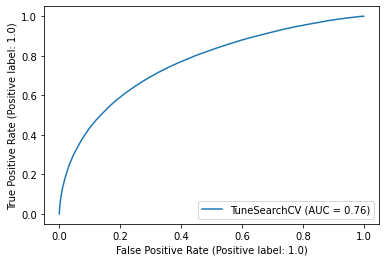

In [ ]:
yHat = clf.predict(xTest)
print(fbeta_score(yTest['DEP_DEL15'], yHat, beta=2))
print(accuracy_score(yTest['DEP_DEL15'], yHat))
print(precision_score(yTest['DEP_DEL15'], yHat))
print(recall_score(yTest['DEP_DEL15'], yHat))
plot_roc_curve(clf, xTest, yTest['DEP_DEL15'])

In [ ]:
dump(clf, 'rf_up_2thirds_cv_need_check.joblib')
# dump(clf, 'rf_up_2thirds_cv_best_f2_057_test_f2_048_accuracy_075.joblib')

['rf_up_2thirds_cv_best_f2_057_test_f2_048_accuracy_075.joblib']

In [ ]:
clf = load('rf_up_cv_best_f2_077_test_f2_056_accuracy_075.joblib')

In [ ]:
clf.__dict__

{'_base_metric_name': 'f2',
 '_metric_name': 'average_test_f2',
 'base_estimator': RandomForestClassifier(random_state=42),
 'best_estimator': Pipeline(steps=[('me',
                  MEstimateEncoder(cols=['DAY_OF_MONTH', 'DAY_OF_WEEK',
                                         'OP_UNIQUE_CARRIER', 'ORIGIN',
                                         'ORIGIN_STATE_ABR', 'DEST',
                                         'DEST_STATE_ABR'],
                                   m=88.20815624166465)),
                 ('ss', StandardScaler()),
                 ('clf',
                  RandomForestClassifier(criterion='entropy',
                                         min_samples_leaf=15, n_estimators=84,
                                         random_state=42, warm_start=True))]),
 'best_index': 1,
 'best_params': {'clf__criterion': 'entropy',
  'clf__max_samples': None,
  'clf__min_samples_leaf': 15,
  'clf__n_estimators': 84,
  'clf__warm_start': True,
  'me__m': 88.20815624166465},
 'best_

In [ ]:
import joblib

In [ ]:
!pip install ray

In [ ]:
from ray.util.joblib import register_ray

In [ ]:
# cross validation with the parameters grid
# very slow (at least with svc, don) hummmmm
# logistic regression much faster
# attempt to boost up (probably not) with joblib and ray
register_ray() # only set once

In [ ]:
with joblib.parallel_backend('ray'):
  grid_search.fit(xTrain, yTrain['DEP_DEL15'])

(pid=3682) /usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
(pid=3682)   import pandas.util.testing as tm
(pid=3680) /usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
(pid=3680)   import pandas.util.testing as tm
(pid=3681) /usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
(pid=3681)   import pandas.util.testing as tm
(pid=3683) /usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
(pid=3683)   import pandas.util.testing as tm


In [ ]:
# check params
grid_search.get_params()

In [ ]:
grid_search.best_score_

0.37529687599368017

In [ ]:
# bad lol, need more models and tuning (hopefully)
# otherwise have to check and explain why kaggel get 80%
# i remember they have some
grid_search.score(xTest, yTest['DEP_DEL15'])

0.37853259821876084

In [ ]:
# for saving data
from joblib import dump, load

In [ ]:
dump(grid_search, 'dct_v0.joblib')

['dct_v0.joblib']

In [ ]:
grid_search = load('dct_v0.joblib')

In [ ]:
# categorical nb?
xTrain['DISTANCE'] = pd.cut(xTrain['DISTANCE'], bins=[0,500,1000,np.inf], labels = ['short', 'medium', 'long'])
xTrain['CRS_DEP_TIME'] = pd.cut(xTrain['CRS_DEP_TIME'], bins=[0,480,960,np.inf], labels = ['morning', 'noon', 'evening'])
xTest['DISTANCE'] = pd.cut(xTest['DISTANCE'], bins=[0,500,1000,np.inf], labels = ['short', 'medium', 'long'])
xTest['CRS_DEP_TIME'] = pd.cut(xTest['CRS_DEP_TIME'], bins=[0,480,960,np.inf], labels = ['morning', 'noon', 'evening'])
xTrain = xTrain.iloc[:,0:9]
xTest = xTest.iloc[:,0:9]

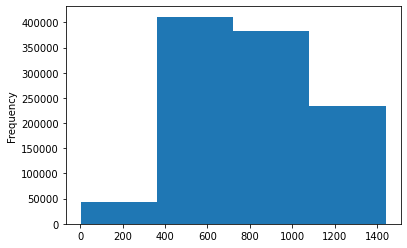

In [ ]:
xTrain['CRS_DEP_TIME'].plot(kind="hist", bins = 4)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import CategoricalNB

In [ ]:
le = LabelEncoder()
for c in xTrain.columns:
  xTrain[c] = le.fit_transform(xTrain[c])
  xTtest[c] = le.transform(xTest[c])

In [ ]:
cnb = CategoricalNB()
cnb.fit(xTn, yTrain['ARR_DELAY'])
f1_score(yTest['ARR_DELAY'], cnb.predict(xTt))

In [ ]:
# 分解尝试？
me = MEstimateEncoder()
ss = StandardScaler()
dtc = DecisionTreeClassifier(random_state=42)

In [ ]:
me.fit(xTrain, yTrain['DEP_DEL15'])
xTrain = me.transform(xTrain)
xTest = me.transform(xTest)

In [ ]:
ss.fit_transform(xTrain)
ss.transform(xTest)

array([[-0.2870776 , -1.93526265, -1.45238282, ...,  0.15983674,
        -0.57956676, -1.20946058],
       [-1.09673412, -0.67720868, -0.47748726, ..., -1.25599743,
         0.05781053, -1.86885456],
       [ 1.49908133,  1.41772996, -0.58386763, ...,  0.1225369 ,
        -0.20809531,  0.35599556],
       ...,
       [ 0.98763519,  1.41772996, -1.45238282, ...,  0.15983674,
         0.67526978,  0.35599556],
       [ 1.39449227,  0.31753777,  0.22964285, ...,  1.27984552,
        -0.14186782,  0.24976882],
       [-0.2870776 ,  0.42648827,  1.55145982, ..., -0.04610514,
        -0.57956676,  0.1951328 ]])

In [ ]:
dtc.fit(xTrain,yTrain['DEP_DEL15'])

DecisionTreeClassifier(random_state=42)

In [ ]:
dtc.score(xTest,yTest['DEP_DEL15'])

0.7245710366361997

In [ ]:
pipe.fit(xTrain,yTrain['DEP_DEL15'])
pipe.score(xTest,yTest['DEP_DEL15'])

0.7245369317751201

In [ ]:
precision_score(yTest['DEP_DEL15'], pipe.predict(xTest))

0.3656887112623139

In [ ]:
yTrain['DEP_DEL15'].value_counts()

0.0    843165
1.0    228396
Name: DEP_DEL15, dtype: int64